In [2]:
#1) 10 % på rigtig model (gauss) og bedte parameter til den (Signe kører gauss simpel, astrid finder bedste gauss parametre) Kør sammen i bunden til sidst på advaced gauss
#2) Evaluation: f-score, mse, acc. for både liar og bigcorp. Både val og test. (Signe laver for hverr)
#3) svm på lille dataset (peter)
#3) Conclusion: visualizer alt i rapport

# Importing all packages

In [3]:
%matplotlib inline
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cleantext import clean
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib.pyplot import bar
from matplotlib.pyplot import xticks
from matplotlib.pyplot import show
from sklearn.ensemble import RandomForestClassifier
import csv
from nltk.stem import PorterStemmer
import warnings
import pickle
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from pandas.core.common import SettingWithCopyWarning
import scipy.sparse as sp
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import numpy as np
from scipy.sparse import csr_matrix
import io
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import joblib
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns


size = 1000000
get_chunk_size = 50000

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simonmork/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Getting The news_cleaned csv and train, val, test

In [4]:
#Getting News_cleaned_2018_02_13
#csv_textfilereader = pd.read_csv('/Users/simonmork/Desktop/GitHub/FinalProjectDS/news_cleaned_2018_02_13.csv', chunksize=1000000, iterator=True)


In [5]:
# Get Liar train datataset
print("Getting liar train csv...")
LiarTrain = pd.read_csv('/Users/simonmork/Desktop/GitHub/FinalProjectDS/liar_dataset/train.tsv', sep='\t')
# Save the third column as a list
LiarTrainArticles = LiarTrain.iloc[:, 2].values.tolist()
LiarTrainLables = LiarTrain.iloc[:, 1].values.tolist()
print(LiarTrainArticles[0])
print(LiarTrainLables[0])

Getting liar train csv...
When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
half-true


In [6]:
# Get Liar Val datataset
print("Getting liar val csv...")
LiarVal = pd.read_csv('/Users/simonmork/Desktop/GitHub/FinalProjectDS/liar_dataset/valid.tsv', sep='\t')



Getting liar val csv...


In [7]:
# Get Liar test datataset
print("Getting liar test csv...")
LiarTest = pd.read_csv('/Users/simonmork/Desktop/GitHub/FinalProjectDS/liar_dataset/test.tsv', sep='\t')




# Save the third column as a list
LiarTestArticles = LiarTest.iloc[:, 2].values.tolist()
LiarTestLables = LiarTest.iloc[:, 1].values.tolist()
print(LiarTestArticles[0])
print(LiarTestLables[0])


Getting liar test csv...
Wisconsin is on pace to double the number of layoffs this year.
false


# Defining all the functions we need

#### The cleantext function specifications

In [8]:
# Define settings for cleaning
def clean_text(text):
    """Calls the clean function from cleantext clean on a string"""
    t = clean(text,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=True,         # fully strip line breaks as opposed to only normalizing them NOT WORKING?
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=True,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="URL",
    replace_with_email="EMAIL",
    replace_with_phone_number="PHONE",
    replace_with_number="NUM",
    replace_with_digit="0",
    replace_with_currency_symbol="CUR",
    lang="en",                       # set to 'de' for German special handling
    )
    return t


pd.set_option("display.max_colwidth", 10000000)    
print("Done")    

Done


#### The clean function for a df column

In [9]:
    # Clean dataframe function
def clean_df(df, label, chunk_nr):
        column_names = list(df.columns)

        # unique words and num before clean
        words = df[label].str.split().explode()
        unique_words_before = set(words)
        
        # Count the number of words in the list
        total_word_count_before = len(words)
        #print("Total word count before clean: ", total_word_count_before, "\n")


        print("Cleaning chunk: ", chunk_nr)
        df.loc[:, label] = df[label].apply(clean_text)

        words_clean = df[label].str.split().explode()
        unique_words_clean = set(words_clean)
        total_word_count_clean = len(words_clean)


        print("Tokenizing and removing stopwords for chunk: ", chunk_nr)
        stop_words = set(stopwords.words('english'))
        df.loc[:, label] = df[label].apply(nltk.word_tokenize)
        df.loc[:, label] = df[label].apply(lambda row: [w for w in row if w not in stop_words])
        
        unique_words_stop = df[label].explode().unique()
        #unique_words_stop = len(unique_words_stop)
        total_word_count_stop = df[label].explode().count()

    
        print("Stemming chunk nr:", chunk_nr)
        porter = PorterStemmer()
        df.loc[:, label] = df[label].apply(lambda row: [porter.stem(w) for w in row])


        unique_words_stem = df[label].explode().unique()
        #unique_words_stem = len(unique_words_stem)
        total_word_count_stem = df[label].explode().count()

        


        print("Done with chunk: ", chunk_nr, "\n")


        return df, unique_words_before, unique_words_clean, unique_words_stop, unique_words_stem, total_word_count_before, total_word_count_clean, total_word_count_stop, total_word_count_stem
        


#### Function to vectorize a set and unique words to get same dimensions
##### X_vectoriser is a function that takes in a list of text data as input, concatenates the words in each string, and transforms the resulting text data into a sparse matrix representation using the CountVectorizer from scikit-learn. The resulting matrix can be used as input to machine learning algorithms.

In [10]:
def X_vectoriser(vectee, unique_words):
    vectee = [' '.join(words) for words in vectee]
    vectorizer = CountVectorizer(vocabulary=unique_words)
    vectee = vectorizer.fit_transform(vectee)
    return vectee

#### Function to make the labels binary.
##### make_bin is a function that takes in a list of categorical data and converts it into a list of binary labels. The function iterates through the input list and assigns a binary label of 0 to each non-'fake' element and a label of 1 to each 'fake' element. The resulting binary labels are returned as a list, which can be used as target values for machine learning algorithms.

In [11]:
def make_bin(to_bin):
    to_bin = np.asarray(to_bin)
    reliable = 0
    fake = 0
    bin_list = []
    for i in range(len(to_bin)):
        if to_bin[i] == "nan":
            print("nan")
        if to_bin[i] == "Na":
            print("Na")
        if to_bin[i] != 'fake' and to_bin[i] != 'satire' and to_bin[i] != 'conspiracy' and to_bin[i] != 'junksci' and to_bin[i] != 'hate' and to_bin[i] != 'clickbait' and to_bin[i] != 'unreliable' and to_bin[i] != 'rumor' and to_bin[i] != 'false' and to_bin[i] != 'pants-fire' and to_bin[i]!='nan':
            bin_list.append(0)
            reliable = reliable +1
        else:
            bin_list.append(1)
            fake = fake+1
        #print(to_bin[i])
    return bin_list, fake, reliable

In [12]:
def remove_duplicates_and_nan(df, label1, label2):

    # Count the number of articles before 
    n_articles_before = df.shape[0]
    
    # Remove rows with NaN in the specified column
    n_articles_removed_NA = n_articles_before - df.dropna(subset=[label1]).shape[0]
    df = df.dropna(subset=[label2])
    
    # Drop duplicates based on the specified column
    df.drop_duplicates(subset=[label1], keep='first', inplace=True)

    # Reset the index of the DataFrame
    df.reset_index(drop=True, inplace=True)
    
    # Count the number of articles after
    n_articles_after = df.shape[0]
    
    # Calculate the number of articles that were removed
    n_articles_removed_duplicates = n_articles_before - n_articles_after - n_articles_removed_NA

    # Print the number of articles removed
    print(f"Removed {n_articles_removed_NA} articles due to NaN values.")
    print(f"Removed {n_articles_removed_duplicates} articles due to duplicates.\n")
    
    
    return df

#### How to save data to csv file

In [13]:
""" # Save original data to CSV
first_chunk.to_csv('original_data.csv', index=False)

# Clean the data
cleaned_df = clean_df(first_chunk)

# Save cleaned data to CSV
cleaned_df.to_csv('cleaned_data.csv', index=False) """

" # Save original data to CSV\nfirst_chunk.to_csv('original_data.csv', index=False)\n\n# Clean the data\ncleaned_df = clean_df(first_chunk)\n\n# Save cleaned data to CSV\ncleaned_df.to_csv('cleaned_data.csv', index=False) "

## The big Dataset

#### Cleaning the big dataset

In [14]:
def Do_all_cleaning():    
    unique_words_before_big = set()
    unique_words_clean_big = set()
    unique_words_stop_big = set()
    unique_words_stem_big = set()

    total_word_count_before_big = 0
    total_word_count_clean_big = 0
    total_word_count_stop_big = 0
    total_word_count_stem_big = 0

    all_of_df = csv_textfilereader.get_chunk(size)


    chunk_to_from = all_of_df.iloc[900000:1000000]
    chunk_to_from.to_csv('9_10.csv', mode='w', index=False, quoting=csv.QUOTE_ALL)

    #Removing duplicates and Na/nan from big dataset 
    chunk_to_from = remove_duplicates_and_nan(chunk_to_from, 'title', 'content')

    chunks = [chunk_to_from.iloc[j:j+get_chunk_size] for j in range(0, size, get_chunk_size)]
    chunk_nr = 0
    for chunk in chunks:
        chunk_nr += 1
        df, unique_words_before, unique_words_clean, unique_words_stop, unique_words_stem, total_word_count_before, total_word_count_clean, total_word_count_stop, total_word_count_stem = clean_df(chunk, 'content', chunk_nr)

        df.to_csv('big_df.csv', mode='a', index=False, quoting=csv.QUOTE_ALL)

        unique_words_before_big.update(unique_words_before)
        unique_words_clean_big.update(unique_words_clean)
        unique_words_stop_big.update(unique_words_stop)
        unique_words_stem_big.update(unique_words_stem)

        total_word_count_before_big += total_word_count_before
        total_word_count_clean_big += total_word_count_clean
        total_word_count_stop_big += total_word_count_stop
        total_word_count_stem_big += total_word_count_stem



    with open('unique_words_before_big.pkl', 'wb') as f:
        pickle.dump(unique_words_before_big, f)

    with open('unique_words_clean_big.pkl', 'wb') as f:
        pickle.dump(unique_words_clean_big, f)
        
    with open('unique_words_stop_big.pkl', 'wb') as f:
        pickle.dump(unique_words_stop_big, f)

    with open('unique_words_stem_big.pkl', 'wb') as f:
        pickle.dump(unique_words_stem_big, f)


    count_list = [total_word_count_before_big, total_word_count_clean_big, total_word_count_stop_big, total_word_count_stem_big]
    with open('counts.pkl', 'wb') as f:
        pickle.dump(count_list, f)


#Do_all_cleaning()



#### retrieve the dataframe stored in big_df, the lists of unique words and the total and unique word counts.

In [15]:
def convert_to_list(x):
    return x.split(',')

big_df = pd.read_csv('/Users/simonmork/Desktop/GitHub/FinalProjectDS/big_df.csv', chunksize=size, iterator=True, converters={'content': convert_to_list})
big_df = big_df.get_chunk(size)

/var/folders/r3/3zlyy5351w142fn8p5ldy2k00000gn/T/ipykernel_18285/4103338480.py:5: DtypeWarning: Columns (0,1,11,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  big_df = big_df.get_chunk(size)


In [16]:
with open('/Users/simonmork/Desktop/GitHub/FinalProjectDS/unique_words_before_big.pkl', 'rb') as f:
    unique_words_before_big = pickle.load(f)

with open('/Users/simonmork/Desktop/GitHub/FinalProjectDS/unique_words_clean_big.pkl', 'rb') as f:
    unique_words_clean_big = pickle.load(f)

with open('/Users/simonmork/Desktop/GitHub/FinalProjectDS/unique_words_stop_big.pkl', 'rb') as f:
    unique_words_stop_big = pickle.load(f)

with open('/Users/simonmork/Desktop/GitHub/FinalProjectDS/unique_words_stem_big.pkl', 'rb') as f:
    unique_words_stem_big = pickle.load(f)

with open('/Users/simonmork/Desktop/GitHub/FinalProjectDS/counts.pkl', 'rb') as f:
    count_list = pickle.load(f)


total_word_count_before_big = count_list[0]
total_word_count_clean_big = count_list[1]
total_word_count_stop_big = count_list[2]
total_word_count_stem_big = count_list[3]

#print(total_word_count_before_big)
#print(total_word_count_clean_big)
#print(total_word_count_stop_big)
#print(total_word_count_stem_big)
#print(unique_words_before_big)
#print(unique_words_clean_big)
#print(unique_words_stop_big)
#print(unique_words_stem_big)




#### Getting some stats on the big dataset

In [17]:
    #Part 1 - Task 2
def get_stats():
        print("Counting number of urls, dates and num, and fake news and trump")
        url = 0
        num = 0
        trump=0
        fakenews = 0
        notfake = 0


        for index, row in big_df.iterrows():
            for word in big_df.at[index,'content']:
                #print(word)
                if word == 'url':
                    url = url+1
                if word == 'num':
                    num = num+1
                if word == 'trump':
                    trump = trump+1
            if big_df.at[index,'type'] == 'fake':
                fakenews = fakenews+1
            else:
                notfake = notfake+1
        print("Num urls: ", url)
        print("Num num: ", num)
        print("Num trump: ", trump)
        print("Num fake: ", fakenews)
        print("Num notfake: ", notfake)

#get_stats()

Visualization of the key properties of the dataset

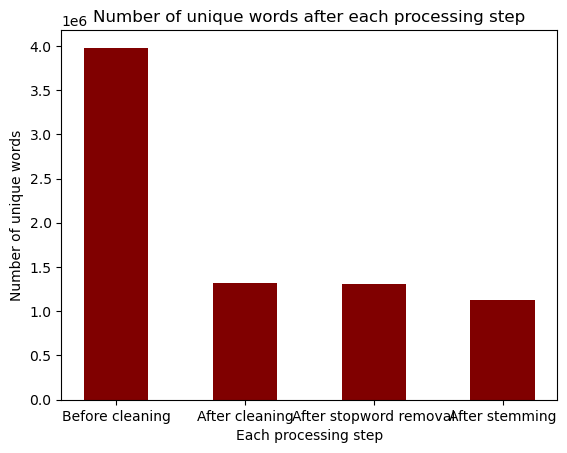

In [18]:
# Plotting the bar chart 
data = {'Before cleaning': len(unique_words_before_big), 'After cleaning': len(unique_words_clean_big), 'After stopword removal': len(unique_words_stop_big), 'After stemming': len(unique_words_stem_big)}
dataset = list(data.keys())
values = list(data.values())
bar(dataset, values, color = 'maroon', width = 0.5)
plt.xlabel('Each processing step')
plt.ylabel('Number of unique words')
plt.title('Number of unique words after each processing step')
plt.rcParams["figure.figsize"] = [15.0, 5.0]
font = {'size' : 14}
plt.rc('font', **font)
plt.show()

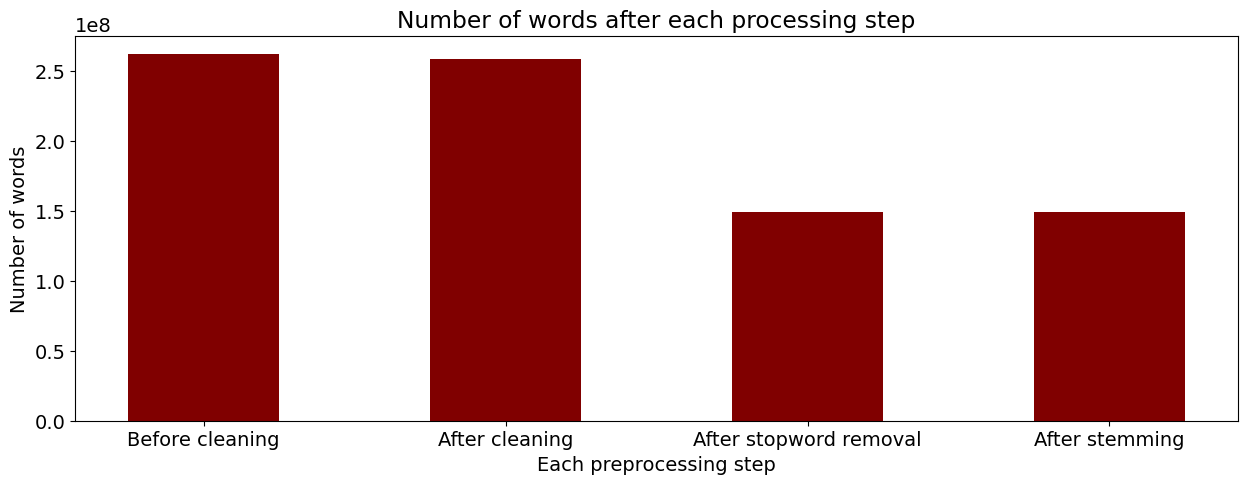

In [19]:
# Plotting the bar chart 
data = {'Before cleaning': total_word_count_before_big, 'After cleaning': total_word_count_clean_big, 'After stopword removal': total_word_count_stop_big, 'After stemming': total_word_count_stem_big}
dataset = list(data.keys())
values = list(data.values())
bar(dataset, values, color = 'maroon', width = 0.5)
plt.xlabel('Each preprocessing step')
plt.ylabel('Number of words')
plt.title('Number of words after each processing step')
plt.rcParams["figure.figsize"] = [10.0, 5.0]
font = {'size' : 14}
plt.rc('font', **font)
plt.show()

#### Splitting the data
##### This code splits a DataFrame df into training, validation, and testing sets, with a 80:10:10 ratio. The X variable contains the content of the articles, while the y variable contains the type of the articles (reliable/fake).

In [20]:
X, y = big_df.content, big_df['type']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)


In [21]:
print(len(unique_words_stem_big))
unique_words_stem_big = [word for word in unique_words_stem_big if not isinstance(word, float)]


1129231


#### Transform text big csv data into a sparse matrix representation
##### To make predictions later

In [22]:
def vectorize_and_save_xes():        
        X_train_vec = X_vectoriser(X_train, unique_words_stem_big)
        X_val_vec = X_vectoriser(X_val, unique_words_stem_big)
        X_test_vec = X_vectoriser(X_test, unique_words_stem_big)
        sp.save_npz("X_train_vec.npz", X_train_vec)
        sp.save_npz("X_val_vec.npz", X_val_vec)
        sp.save_npz("X_test_vec.npz", X_test_vec)
        return X_train_vec, X_val_vec, X_test_vec
#X_train_vec, X_val_vec, X_test_vec = vectorize_xes()

In [23]:
X_train_vec = sp.load_npz("X_train_vec.npz")
X_val_vec = sp.load_npz("X_val_vec.npz")
X_test_vec = sp.load_npz("X_test_vec.npz")

### Handling the labels for big data

In [24]:
y_train_bin, LabelFa, LabelRe  = make_bin(y_train)
y_val_bin, no1, no2 = make_bin(y_val)
y_test_bin, no3, no4 = make_bin(y_test)

with open('y_train_bin.pkl', 'wb') as f:
        pickle.dump(y_train_bin, f)
with open('y_val_bin.pkl', 'wb') as f:
        pickle.dump(y_val_bin, f)
with open('y_test_bin.pkl', 'wb') as f:
        pickle.dump(y_test_bin, f)
with open('y_variables.pkl', 'wb') as f:
        pickle.dump([LabelFa, LabelRe, no1, no2, no3, no4], f)


In [25]:
with open('y_train_bin.pkl', 'rb') as f:
    y_train_bin = list(pickle.load(f))
with open('y_val_bin.pkl', 'rb') as f:
    y_val_bin = list(pickle.load(f))
with open('y_test_bin.pkl', 'rb') as f:
    y_test_bin = list(pickle.load(f))
with open('y_variables.pkl', 'rb') as f:
    y_vars = list(pickle.load(f))
LabelFa = y_vars[0]
LabelRe = y_vars[1]
no1 = y_vars[2]
no2 = y_vars[3]
no3 = y_vars[4]
no = y_vars[5]

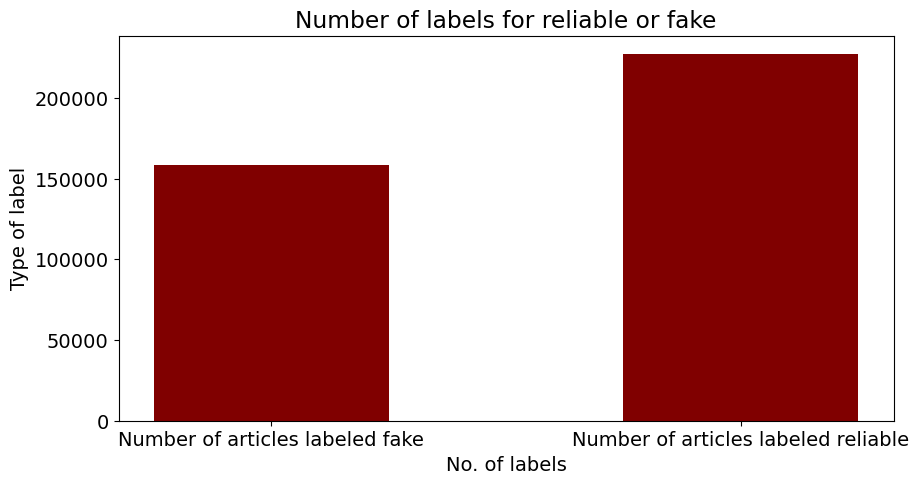

In [26]:
# Bar chart showing number of fake labels and number of reliable
data = {'Number of articles labeled fake': LabelFa, 'Number of articles labeled reliable': LabelRe }
labels = list(data.keys())
values = list(data.values())
bar(labels, values, color = 'maroon', width= 0.5)
plt.xlabel('No. of labels')
plt.ylabel('Type of label')
plt.title('Number of labels for reliable or fake')
plt.rcParams["figure.figsize"] = [10.0, 5.0]
font = {'size' : 14}
plt.rc('font', **font)
plt.show()

## The Liar dataset

#### Cleaning the Liar dataset

In [27]:
# Removing duplicates and Na/nan from liar datasets

LiarTest.columns = ['col1', 'label', 'content', 'title', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14']
LiarTest = remove_duplicates_and_nan(LiarTest, 'title', 'content')

LiarVal.columns = ['col1', 'label', 'content', 'title', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14']
LiarVal = remove_duplicates_and_nan(LiarVal, 'title', 'content')

LiarTrain.columns = ['col1', 'label', 'content', 'title', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14']
LiarTrain = remove_duplicates_and_nan(LiarTrain, 'title', 'content')

Removed 0 articles due to NaN values.
Removed 534 articles due to duplicates.

Removed 0 articles due to NaN values.
Removed 549 articles due to duplicates.

Removed 2 articles due to NaN values.
Removed 6409 articles due to duplicates.



In [28]:
#X_val_liar, k1, k2,k3, UWC = clean_df(LiarVal, 2)
LiarVal.columns = ['col1', 'label', 'content', 'title', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14']
#LiarVal = LiarVal.rename(columns={2: 'content'})
#print("Headers: ", LiarVal.columns.values)
#print(LiarVal)
Liar_df, unique_words_before_liar, unique_words_clean_liar, unique_words_stop_liar, unique_words_stem_liar, total_word_count_liar, total_word_count_liar, total_word_count_liar, total_word_count_liar = clean_df(LiarVal, 'content', 1)

Cleaning chunk:  1
Tokenizing and removing stopwords for chunk:  1
Stemming chunk nr: 1
Done with chunk:  1 



#### Vectorizing the liar datset and saving tofile

In [29]:
X_val_liar = X_vectoriser(Liar_df.content, unique_words_stem_big)
sp.save_npz("X_val_liar.npz", X_val_liar)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


#### Loading file

In [30]:
X_val_liar = sp.load_npz("X_val_liar.npz")

#### Making the labels for liar dataset binary and saving to file

In [31]:
y_val_liar, no5, no6 = make_bin(Liar_df.label)

with open('y_val_liar.pkl', 'wb') as f:
        pickle.dump(y_val_liar, f)

#### Getting y_val_liar file

In [32]:
with open('y_val_liar.pkl', 'rb') as f:
    y_val_liar = list(pickle.load(f))

#### Getting fake and reliable for liar. This lets us see if we overfit by just predicting fake.

In [33]:
fake = 0
reliable = 0
for elm in y_val_liar:
    if elm == 1:
        fake +=1
    else:
        reliable +=1
print("reliable: ", reliable)
print("unreliable: ", fake)
print("percent fake: ", fake/(reliable+fake))

reliable:  520
unreliable:  214
percent fake:  0.29155313351498635


In [ ]:
#Run everything above this.

## Models:

### A simple logistic model:

#### Training on FakeNewsCorpus and predicting on the FakeNewsCorpus val dataset

In [ ]:
simple_log_model = LogisticRegression(max_iter=100000)
simple_log_model.fit(X_train_vec, y_train_bin)
y_pred = simple_log_model.predict(X_val_vec)

acc_simple_log = accuracy_score(y_val_bin, y_pred)
print("Accuracy of simple logistic regression: ", acc_simple_log)


# save the final trained model to a file
filename_simple_log_model = 'simple_log_model.joblib'
joblib.dump(simple_log_model, filename_simple_log_model)



#10000 and chunks 1000: 0.915
#100.000 and chunk 10.000: 0.917
#1000000 and chunk 50000: 0.88


Accuracy of simple logistic regression:  0.880473790113469


['simple_log_model.joblib']

In [47]:
# load the saved model from a file
filename_simple_log_model = 'simple_log_model.joblib'
simple_log_model = joblib.load(filename_simple_log_model)

In [48]:
y_pred = simple_log_model.predict(X_val_vec)
acc_simple_log = accuracy_score(y_val_bin, y_pred)
print("Accuracy of simple logistic regression: ", acc_simple_log)

Accuracy of simple logistic regression:  0.880473790113469


### Cofusion matrix simple logistic model:

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     28402
           1       0.87      0.83      0.85     19805

    accuracy                           0.88     48207
   macro avg       0.88      0.87      0.88     48207
weighted avg       0.88      0.88      0.88     48207



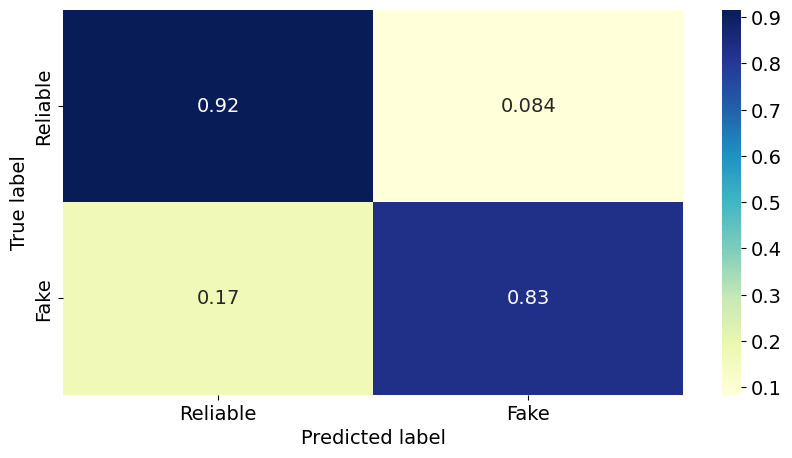

In [ ]:
# generate class probabilities and select cutoff
probas = simple_log_model.predict_proba(X_val_vec)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_bin, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_bin, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Predicting the simple log model on the liar validation set: 

In [ ]:
y_pred_liar = simple_log_model.predict(X_val_liar)

acc_simple_log_liar = accuracy_score(y_val_liar, y_pred_liar)
print(accuracy_score(y_val_liar, y_pred_liar))

#10000 and chunks 1000: 0.292
#100.000 and chunk 10.000: 0.67
#1000000 and chunk 50000: 0.6948228882833788

0.6811989100817438


              precision    recall  f1-score   support

           0       0.71      0.93      0.81       520
           1       0.29      0.07      0.11       214

    accuracy                           0.68       734
   macro avg       0.50      0.50      0.46       734
weighted avg       0.59      0.68      0.60       734



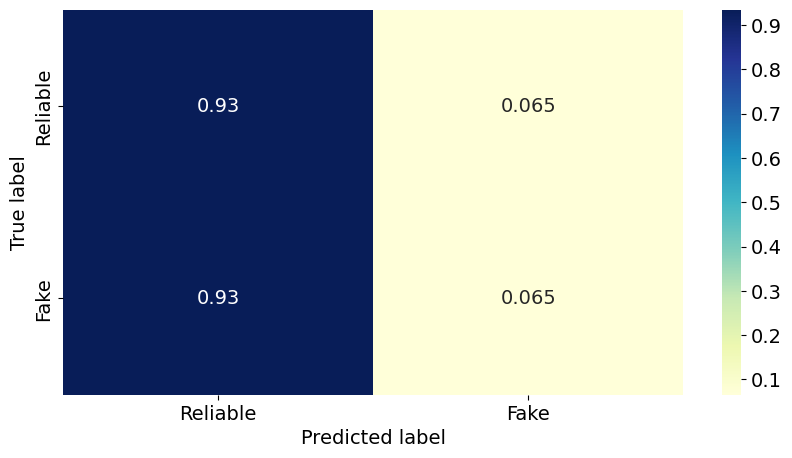

In [ ]:
# generate class probabilities and select cutoff
probas = simple_log_model.predict_proba(X_val_liar)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_liar, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_liar, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Simlpe logistic model with meta (author and domain)

#### Make the data include the authors and domains

In [42]:

for index, row in big_df.iterrows():
    #print("df.at[index,'authors']", df.at[index,'authors'])
    if big_df.at[index,'authors'] != "nan":
        split_str = str(big_df.at[index,'authors']).split(", ")
        for word in split_str:
            author_str = "author: " + word.lower()
            big_df.at[index,'content'].append(author_str)
    if  big_df.at[index,'domain'] != "nan":
        domain_str = "domain: " + str(big_df.at[index,'domain'])
        big_df.at[index,'content'].append(domain_str.lower())


#### get the x_train and x_val and y_train and y_val for 

In [43]:
X_meta, y_meta = big_df.content, big_df['type']


X_train_meta, X_temp_meta, y_train_meta, y_temp_meta = train_test_split(X_meta, y_meta, test_size = 0.2, random_state = 0)
X_test_meta, X_val_meta, y_test_meta, y_val_meta = train_test_split(X_temp_meta, y_temp_meta, test_size = 0.5, random_state = 0)

X_train_vec_meta = X_vectoriser(X_train_meta, unique_words_stem_big)
X_val_vec_meta = X_vectoriser(X_val_meta,unique_words_stem_big)
X_test_vec_meta = X_vectoriser(X_test_meta, unique_words_stem_big)

y_train_bin_meta, LabelFa, LabelRe  = make_bin(y_train_meta)
y_val_bin_meta, LabelFa, LabelRe  = make_bin(y_val_meta)
y_test_bin_meta, LabelFa, LabelRe = make_bin(y_test_meta)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


#### Train with simple model and meta

In [ ]:
simple_log_model_meta = LogisticRegression(max_iter=100000)
simple_log_model_meta.fit(X_train_vec_meta, y_train_bin_meta)

filename_simple_log_model_meta = 'simple_log_model_meta.joblib'
joblib.dump(simple_log_model, filename_simple_log_model_meta)



#10000 and chunks 1000: 0.946
#100.000 and chunk 10.000: 0.956

['simple_log_model_meta.joblib']

#### load simple model meta

In [44]:
filename_simple_log_model_meta = 'simple_log_model_meta.joblib'
simple_log_model_meta = joblib.load(filename_simple_log_model_meta)

#### Predict simple model and meta

In [45]:
y_pred_meta = simple_log_model_meta.predict(X_val_vec_meta)
acc_simple_log_meta = accuracy_score(y_val_bin_meta, y_pred_meta)
print(accuracy_score(y_val_bin_meta, y_pred_meta))

0.5547949467919596


### Cofusion matrix simple logistic model with meta:

              precision    recall  f1-score   support

           0       0.57      0.52      0.54     28402
           1       0.38      0.43      0.41     19805

    accuracy                           0.48     48207
   macro avg       0.48      0.47      0.47     48207
weighted avg       0.49      0.48      0.49     48207



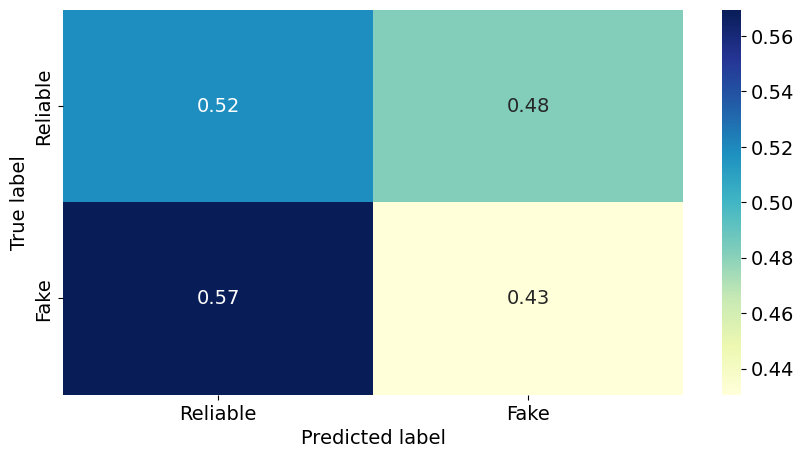

In [ ]:
# generate class probabilities and select cutoff
probas = simple_log_model_meta.predict_proba(X_val_vec_meta)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_bin_meta, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_bin_meta, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Comparing the simple model without metadata and the simple model with metadata:

In [49]:
#Comparison of acc bewteen simple log models

acc_diff_logs = abs(acc_simple_log_meta - acc_simple_log)
print(acc_diff_logs)

0.3256788433215094


### Gaussion naive baiers model:


In [ ]:
#filename
loaded_simple_nb_model = joblib.load("simple_nb_model_' + '150' + '.joblib")
last_processed_chunk = 151


#More memory?
%env KMP_DUPLICATE_LIB_OK=TRUE

# create a RandomUnderSampler instance
rus = RandomUnderSampler(random_state=0)

# create an instance of the Gaussian Naive Bayes model
simple_nb_model = GaussianNB()

#New get_chunk_size
get_chunk_size=1000

# convert X_train_vec and y_train_bin to sparse matrices
X_train_sparse = csr_matrix(X_train_vec)
y_train_sparse = csr_matrix(y_train_bin).T

# create chunks of sparse matrices
chunks = [X_train_sparse[i:i+get_chunk_size,:] for i in range(0, X_train_sparse.shape[0], get_chunk_size)]
labels_chunks = [y_train_sparse[i:i+get_chunk_size,:] for i in range(0, y_train_sparse.shape[0], get_chunk_size)]
chunk_nr = 0

# iterate over the chunks and fit the model
for i in range(last_processed_chunk,  len(chunks)):
    chunk_nr += 1
    print("fitting: ", chunk_nr)
    X_train_resampled, y_train_resampled = rus.fit_resample(chunks[i].toarray(), labels_chunks[i].toarray().ravel())
    print("resampled: ", chunk_nr)
    simple_nb_model.partial_fit(X_train_resampled, y_train_resampled.ravel(), classes=np.unique(y_train_bin))
    
    # save the model incrementally
    if chunk_nr % 50 == 0:
        filename = 'simple_nb_model_' + str(chunk_nr) + '.joblib'
        joblib.dump(simple_nb_model, filename)
    

# save the final trained model to a file
filename = 'simple_nb_model_final.joblib'
joblib.dump(simple_nb_model, filename)

# load the saved model from a file
loaded_simple_nb_model = joblib.load(filename)

# make predictions on the validation set using the loaded model
y_pred_gauss = loaded_simple_nb_model.predict(X_val_vec.toarray())
acc_gauss = accuracy_score(y_val_bin, y_pred_gauss)
print("Accuracy:", acc_gauss)

'\n\n#filename\n#loaded_simple_nb_model = joblib.load("simple_nb_model_\' +  + \'.joblib")\nlast_processed_chunk = 0\n\n#More memory?\n%env KMP_DUPLICATE_LIB_OK=TRUE\n\n# create a RandomUnderSampler instance\nrus = RandomUnderSampler(random_state=0)\n\n# create an instance of the Gaussian Naive Bayes model\nsimple_nb_model = GaussianNB()\n\n#New get_chunk_size\nget_chunk_size=1000\n\n# convert X_train_vec and y_train_bin to sparse matrices\nX_train_sparse = csr_matrix(X_train_vec)\ny_train_sparse = csr_matrix(y_train_bin).T\n\n# create chunks of sparse matrices\nchunks = [X_train_sparse[i:i+get_chunk_size,:] for i in range(0, X_train_sparse.shape[0], get_chunk_size)]\nlabels_chunks = [y_train_sparse[i:i+get_chunk_size,:] for i in range(0, y_train_sparse.shape[0], get_chunk_size)]\nchunk_nr = 0\n\n# iterate over the chunks and fit the model\nfor i in range(last_processed_chunk,  len(chunks)):\n    chunk_nr += 1\n    print("fitting: ", chunk_nr)\n    X_train_resampled, y_train_resampled 

In [61]:
filename_gauss = 'simple_nb_model_final.joblib'
simple_nb_model = joblib.load(filename_gauss)

KeyError: 255

In [ ]:
def chunk_array(matrix, chunk_size=100):
    """Generator that yields chunks of the input matrix as arrays."""
    num_samples = matrix.shape[0]
    for chunk_start in range(0, num_samples, chunk_size):
        chunk_end = min(chunk_start + chunk_size, num_samples)
        yield matrix[chunk_start:chunk_end].toarray()
        print("chunk_end: ", chunk_end)

In [ ]:
# generate class probabilities and select cutoff
probas = np.concatenate(
    [simple_nb_model.predict_proba(chunk) for chunk in chunk_array(X_val_vec)],
    axis=0
)

#save probas to a file
np.save('probas.npy', probas)

In [ ]:
probas = np.load("probas.npz")

### Cofusion matrix simple gauss model fake news data:

In [ ]:
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_bin, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_bin, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### predicting the gaussian model on the liar dataset

In [ ]:
y_pred_gauss_liar = simple_nb_model.predict(X_val_liar.toarray())

# evaluate the accuracy of the model's predictions on liar
acc_gauss_liar = accuracy_score(y_val_liar, y_pred_gauss_liar)
print(acc_gauss_liar)

#10000 and chunks 1000: 0.655

"\n\ny_pred_gauss_liar = simple_nb_model.predict(X_val_liar.toarray())\n\n# evaluate the accuracy of the model's predictions on liar\nacc_gauss_liar = accuracy_score(y_val_liar, y_pred_gauss_liar)\nprint(acc_gauss_liar)\n\n#10000 and chunks 1000: 0.655\n\n\n"

### Cofusion matrix simple Gauss model with liar data:

In [ ]:
# generate class probabilities and select cutoff
probas = simple_nb_model.predict_proba(X_val_liar.toarray())
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_liar, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_liar, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Random forrest classifer model:

In [ ]:
# RandomForest model

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer


# Train a Random Forest model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_vec, y_train_bin)

filename_rfc = 'rfc.joblib'
joblib.dump(rfc, filename_rfc)

print("Model is trained")

#output notes: Accuracy: 0.764 when nrows=10.000, runtime 47.8s
#output notes: Accuracy: 0.8575 when nrows=20.000, runtime 1m 53.3s



Model is trained


#### load forrest model

In [ ]:
filename_rfc = 'rfc.joblib'
rfc = joblib.load(filename_rfc)

#### Evaluate the forrest model on the validation for the big fake news corpus

In [ ]:
# Evaluate the model on big corpus
y_pred_forrest = rfc.predict(X_val_vec)
acc_forrest = accuracy_score(y_val_bin, y_pred_forrest)
print('Accuracy:', acc_forrest)

#10000 and chunks 1000: 0.89
#1000000 and chunks 50000: 0.864

Accuracy: 0.8628829837990334


### Cofusion matrix rfc model on fake news data:

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     28402
           1       0.93      0.72      0.81     19805

    accuracy                           0.86     48207
   macro avg       0.88      0.84      0.85     48207
weighted avg       0.87      0.86      0.86     48207



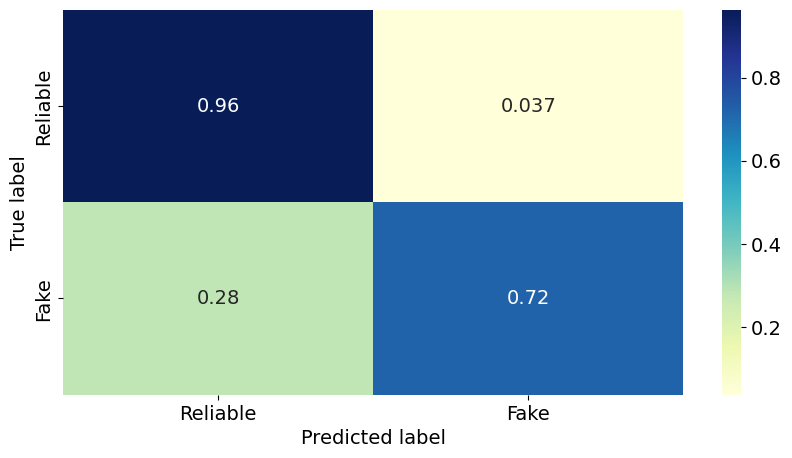

In [ ]:
# generate class probabilities and select cutoff
probas = rfc.predict_proba(X_val_vec)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_bin, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_bin, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Evaluate the forrest model on liar valid 

In [ ]:
# Evaluate the model on liar corpus
y_pred_forrest_liar = rfc.predict(X_val_liar)
acc_forrest = accuracy_score(y_val_liar, y_pred_forrest_liar)
print('Accuracy:', acc_forrest)

#10000 and chunks 1000: 0.291
#1000000 and chunks 50000: 0.707

Accuracy: 0.7084468664850136


### Cofusion matrix simple rfc model on liar data:

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.71      1.00      0.83       520
           1       0.00      0.00      0.00       214

    accuracy                           0.71       734
   macro avg       0.35      0.50      0.41       734
weighted avg       0.50      0.71      0.59       734



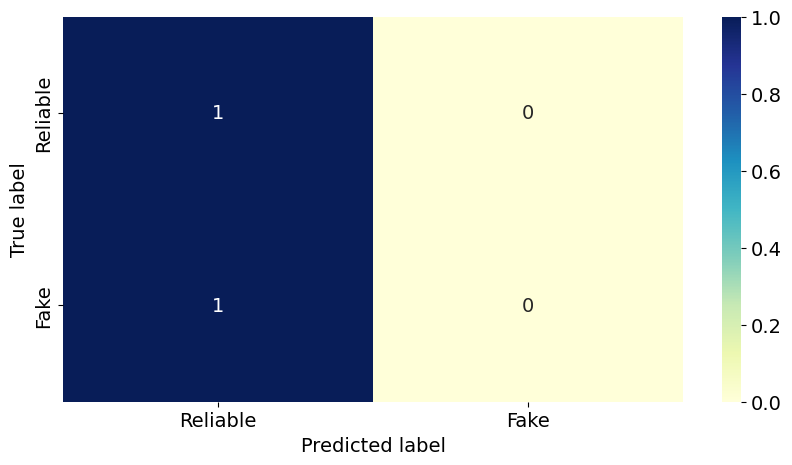

In [ ]:
# generate class probabilities and select cutoff
probas = rfc.predict_proba(X_val_liar)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_liar, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_liar, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Support vector machine model:

In [64]:
# Support Vector Machine (SVM) model
from sklearn.svm import SVC


# Taking a smaller subset of the data to speed up the training process
SVM_size = 10000 # Bigger numbers will take longer to train, 10.000 took 2m 21.1s, 100.000 took more than 14h - but was interrupted.
X_train_subset = X_train_vec[:SVM_size]
y_train_subset = y_train_bin[:SVM_size]


# Train an SVM model
svm = SVC(kernel='rbf', C=1.0, probability=True)
svm.fit(X_train_subset, y_train_subset)
print("Model is trained")

#Output on Cleaned data (big_df):
# SVM_size 15.000 , acc 0.7850666666666667, runtime 4m 38.0s (x2)
# SVM_size 20.000 , acc 0.79315, runtime 15m 21.0s (x2)

#OLD OUTPUT ON NOT CLEANED DATA
#Output note: Accuracy: 0.575, when nrows=1.000, runtime 41.3s
#Output note: Accuracy: 0.62, when nrows=2.000, runtime 1m 42.7s
#Output note: Accuracy: 0.6633, when nrows=3.000, runtime 3m 31.6s
#Output note: Accuracy: 0.67, when nrows=4.000, runtime 7m 31.5s
#Output note: Accuracy: 0.684, when nrows=5.000, runtime 12min 30s
#Output note: Accuracy: 0.7125, when nrows=6.000, runtime 53min 29.7s
#Output note: Accuracy: 0.767, when nrows=10.000, runtime 7h 12min 11.4s

Model is trained


In [65]:
# Saving the trained model to a file
filename_SVM = 'SVM_model.joblib'
joblib.dump(svm, filename_SVM)

['SVM_model.joblib']

In [66]:
# load the saved model from a file
filename_SVM = 'SVM_model.joblib'
svm = joblib.load(filename_SVM)

In [67]:
# Evaluate the model on big corpus

# Taking a smaller subset of the data to speed up the training process
X_val_subset = X_val_vec[:SVM_size] 
y_val_subset = y_val_bin[:SVM_size] 

y_pred_svm = svm.predict(X_val_subset)
acc_svm = accuracy_score(y_val_subset, y_pred_svm)
print('Accuracy:', acc_svm)

#10000 and chunks 1000: 0.889
# size = 10000 accuracy = 0.7784

Accuracy: 0.7784


In [ ]:
# generate class probabilities and select cutoff
probas = svm.predict_proba(X_val_subset)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_subset, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_subset, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

AttributeError: predict_proba is not available when  probability=False

In [ ]:
# Evaluate the model on liar corpus
y_pred_svm_liar = svm.predict(X_val_liar)
acc_svm = accuracy_score(y_val_liar, y_pred_svm_liar)
print('Accuracy:', acc_svm)

#10000 and chunks 1000: 0.291
# size = 10000 accuracy = 0.708446

In [ ]:
# generate class probabilities and select cutoff
probas = svm.predict_proba(X_val_liar)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_liar, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_liar, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## Den komplicerede logistiske schematic:

Accuracy for C=0.1: 0.8779845250689734
Best C: 0.1
              precision    recall  f1-score   support

           0       0.89      0.90      0.90     28402
           1       0.85      0.85      0.85     19805

    accuracy                           0.88     48207
   macro avg       0.87      0.87      0.87     48207
weighted avg       0.88      0.88      0.88     48207



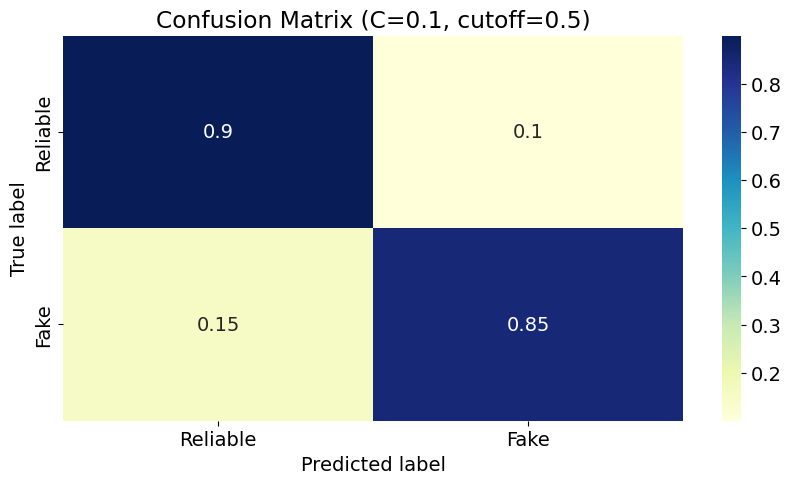

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

Cs = [0.1]
best_accuracy = 0
best_c = 0
best_y_pred = None

# create a RandomUnderSampler instance
rus = RandomUnderSampler(random_state=0)

# fit and transform the training data using RandomUnderSampler
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_vec, y_train_bin)

for c in Cs:
    advanced_log_model = LogisticRegression(max_iter=100000, C=c, class_weight='balanced')
    advanced_log_model.fit(X_train_resampled, y_train_resampled)
    y_pred = advanced_log_model.predict(X_val_vec)
    accuracy = accuracy_score(y_val_bin, y_pred)
    print(f"Accuracy for C={c}: {accuracy}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_c = c
        best_y_pred = y_pred
print("Best C:", best_c)


filename_advanced_log_model = 'advanced_log_model.joblib'
joblib.dump(simple_log_model, filename_advanced_log_model)

#### Load the advanced model

In [ ]:
filename_advanced_log_model = 'advanced_log_model.joblib'
advanced_log_model = joblib.load(filename_advanced_log_model)

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     28402
           1       0.87      0.83      0.85     19805

    accuracy                           0.88     48207
   macro avg       0.88      0.87      0.88     48207
weighted avg       0.88      0.88      0.88     48207



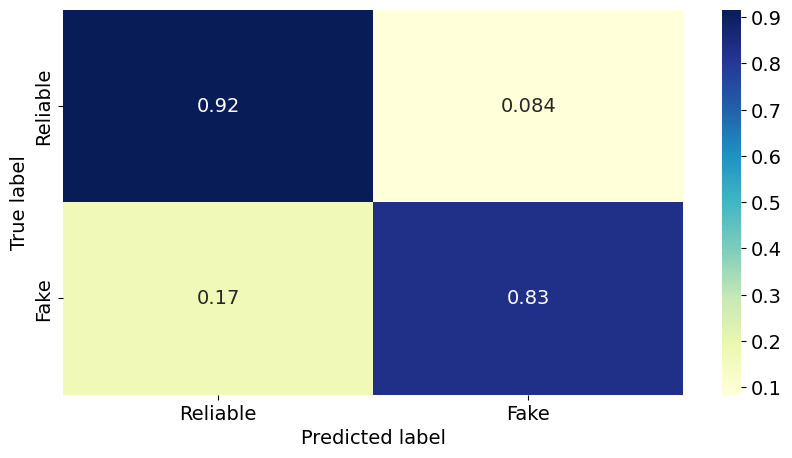

In [ ]:
# generate class probabilities and select cutoff
probas = advanced_log_model.predict_proba(X_val_vec)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_bin, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_bin, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

              precision    recall  f1-score   support

           0       0.71      0.93      0.81       520
           1       0.29      0.07      0.11       214

    accuracy                           0.68       734
   macro avg       0.50      0.50      0.46       734
weighted avg       0.59      0.68      0.60       734



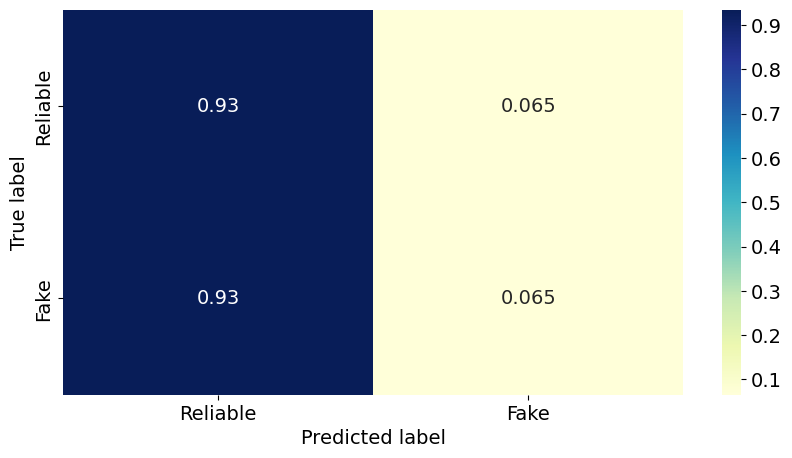

In [ ]:
# generate class probabilities and select cutoff
probas = advanced_log_model.predict_proba(X_val_liar)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_liar, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_liar, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Final testing of all six models

In [50]:
#Getting the Liar test set.
Liar_df_test, unique_words_before_liar_test, unique_words_clean_liar_test, unique_words_stop_liar_test, unique_words_stem_liar_test, total_word_count_liar_test, total_word_count_liar_test, total_word_count_liar_test, total_word_count_liar_test = clean_df(LiarTest, 'content', 1)
LiarTest.columns = ['col1', 'label', 'content', 'title', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14']
X_test_liar = X_vectoriser(Liar_df_test.content, unique_words_stem_big)
X_test_liar = X_vectoriser(Liar_df_test.content, unique_words_stem_big)
y_test_liar, no5, no6 = make_bin(Liar_df_test.label)

Cleaning chunk:  1
Tokenizing and removing stopwords for chunk:  1
Stemming chunk nr: 1
Done with chunk:  1 



/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


#### Simple logistic model

In [35]:
# load the saved model from a file
filename_simple_log_model = 'simple_log_model.joblib'
simple_log_model = joblib.load(filename_simple_log_model)


              precision    recall  f1-score   support

           0       0.88      0.92      0.90     28543
           1       0.87      0.82      0.85     19664

    accuracy                           0.88     48207
   macro avg       0.88      0.87      0.87     48207
weighted avg       0.88      0.88      0.88     48207



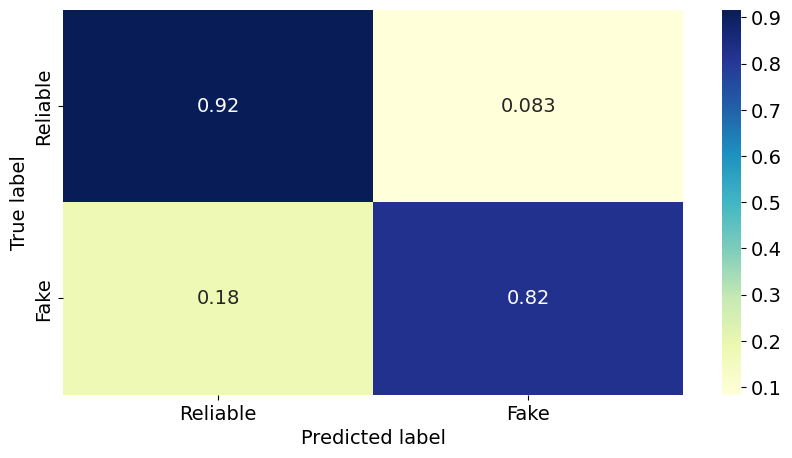

In [36]:
#Big korpus final matrix

y_pred_simple_test = simple_log_model.predict(X_test_vec)
accuracy_simple_test = accuracy_score(y_test_bin, y_pred_simple_test)

# generate class probabilities and select cutoff
probas = simple_log_model.predict_proba(X_test_vec)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_test_bin, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_test_bin, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

              precision    recall  f1-score   support

           0       0.71      0.93      0.80       519
           1       0.24      0.06      0.09       213

    accuracy                           0.67       732
   macro avg       0.48      0.49      0.45       732
weighted avg       0.57      0.67      0.60       732



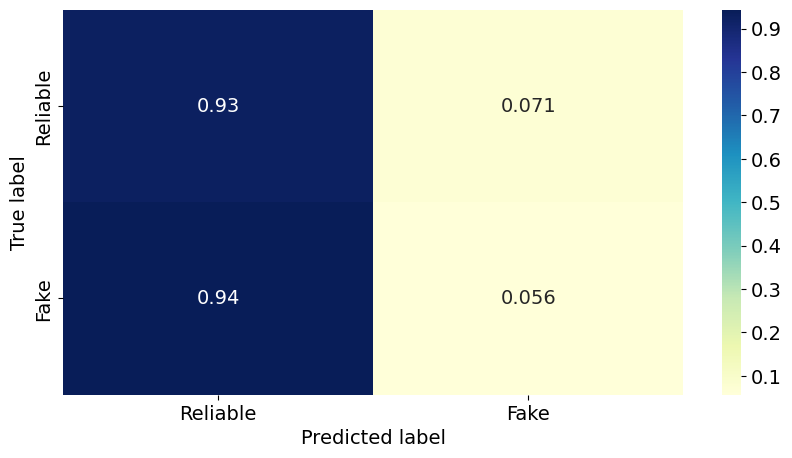

In [37]:
#Liar final matrix
# generate class probabilities and select cutoff
probas = simple_log_model.predict_proba(X_test_liar)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_test_liar, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_test_liar, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Simple logstic w. meta model

In [38]:
filename_simple_log_model_meta = 'simple_log_model_meta.joblib'
simple_log_model_meta = joblib.load(filename_simple_log_model_meta)

              precision    recall  f1-score   support

           0       0.63      0.59      0.61     28543
           1       0.46      0.51      0.48     19664

    accuracy                           0.55     48207
   macro avg       0.54      0.55      0.54     48207
weighted avg       0.56      0.55      0.56     48207



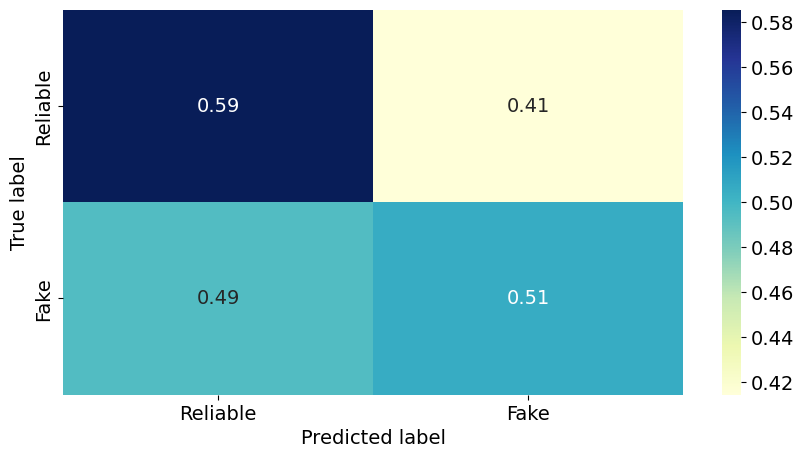

In [51]:

# generate class probabilities and select cutoff
probas = simple_log_model_meta.predict_proba(X_test_vec_meta)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_test_bin_meta, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_test_bin_meta, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Advanced Naive bayes Gaussian model

In [ ]:
filename_gauss = 'simple_nb_model_final.joblib'
simple_nb_model = joblib.load(filename_gauss)

In [ ]:
# generate class probabilities
probas = np.concatenate(
    [simple_nb_model.predict_proba(chunk) for chunk in chunk_array(X_test_vec)],
    axis=0
)
#save probas to a file
np.save('probas_test.npy', probas)

In [ ]:
probas = np.load("probas_test.npz")

In [ ]:
#Select cutoff
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_test_bin, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_test_bin, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# generate class probabilities and select cutoff
probas = simple_nb_model.predict_proba(X_test_liar.toarray())
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_test_liar, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_test_liar, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Randdom Forrest Classifier model

In [52]:
filename_rfc = 'rfc.joblib'
rfc = joblib.load(filename_rfc)

              precision    recall  f1-score   support

           0       0.83      0.97      0.90     28543
           1       0.94      0.72      0.81     19664

    accuracy                           0.87     48207
   macro avg       0.88      0.84      0.85     48207
weighted avg       0.88      0.87      0.86     48207



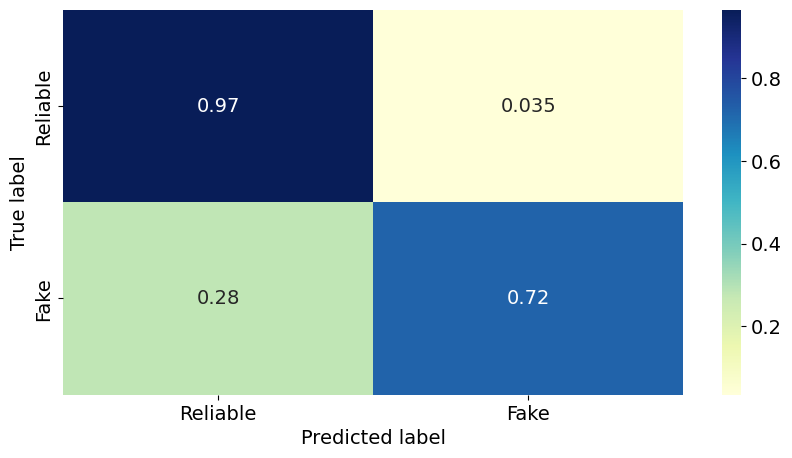

In [53]:
# generate class probabilities and select cutoff
probas = rfc.predict_proba(X_test_vec)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_test_bin, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_test_bin, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.71      1.00      0.83       519
           1       0.00      0.00      0.00       213

    accuracy                           0.71       732
   macro avg       0.35      0.50      0.41       732
weighted avg       0.50      0.71      0.59       732



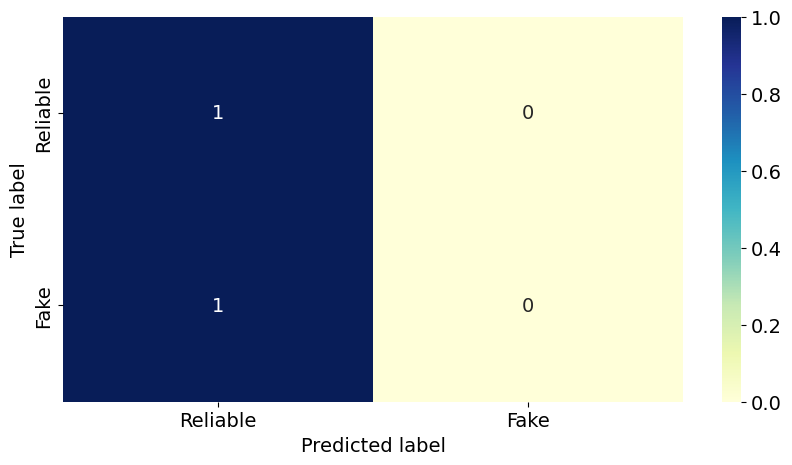

In [54]:
# generate class probabilities and select cutoff
probas = rfc.predict_proba(X_test_liar)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_test_liar, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_test_liar, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Support Vector Machine model

In [ ]:
# load the saved model from a file
filename_SVM = 'SVM_model.joblib'
svm = joblib.load(filename_SVM)

SVM_size = 10000
# Taking a smaller subset of the data to speed up the training process
X_test_subset = X_test_vec[:SVM_size] 
y_test_subset = y_test_bin[:SVM_size] 

In [ ]:
# generate class probabilities and select cutoff
probas = svm.predict_proba(X_test_subset)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_test_subset, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_test_subset, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# generate class probabilities and select cutoff
probas = svm.predict_proba(X_test_liar)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_test_liar, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_test_liar, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Advanced logsitc model

In [55]:
filename_advanced_log_model = 'advanced_log_model.joblib'
advanced_log_model = joblib.load(filename_advanced_log_model)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     28543
           1       0.87      0.82      0.85     19664

    accuracy                           0.88     48207
   macro avg       0.88      0.87      0.87     48207
weighted avg       0.88      0.88      0.88     48207



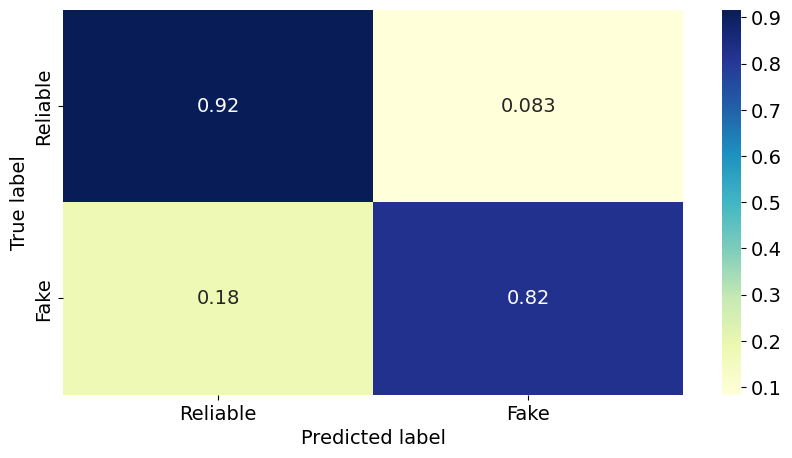

In [56]:
# generate class probabilities and select cutoff
probas = advanced_log_model.predict_proba(X_test_vec)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_test_bin, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_test_bin, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

              precision    recall  f1-score   support

           0       0.71      0.93      0.80       519
           1       0.24      0.06      0.09       213

    accuracy                           0.67       732
   macro avg       0.48      0.49      0.45       732
weighted avg       0.57      0.67      0.60       732



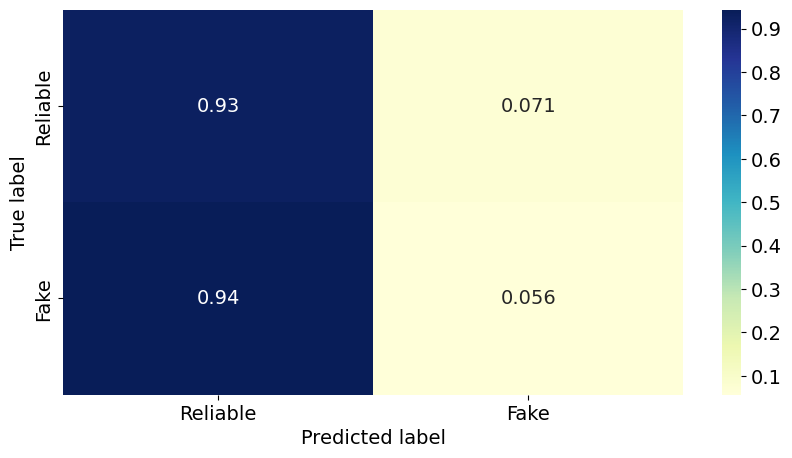

In [57]:
# generate class probabilities and select cutoff
probas = advanced_log_model.predict_proba(X_test_liar)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_test_liar, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_test_liar, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()